# Single cell adaptive spike and oscillations
### 1. Overview
In this section we are going to explore different models's ability to reproduce the bifurcation behavior of single *Dictyostelium* cells. Specifically, as the concentration for cAMP step input is increased, single cell response changes from an adaptive spike to sustained oscillations (Figure 2, below). With this notebook, you can play with different $cAMP_{e}$ inputs and compare the simulated responses ($cAMP_{i}$) produced by different models.
![Figure 2](SC_spike_and_oscillation.png)
<h5><center>Figure2</center></h5>

#### Let's start by importing packages and setting up time scaling parameters

In [5]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline  
from scipy import signal
from scipy.signal import chirp, find_peaks, peak_widths
import pandas as pd
import scipy.io

from Gregor2010_agent_and_pop_FUN import  Gregor2010_agent
from Sgro2015_agent_and_pop_FUN import Sgro2015_agent
from Goldbeter1987_agent_and_pop_FUN import Goldbeter1987_agent_3var
from MaedaLoomis2004_agent_and_pop_FUN import MaedaLoomis2004_agent
from Kamino2017_agent_and_pop_FUN import Kamino2017_agent 

from NB_SC_functions import * 

Nt_Gregor = 6 
Nt_Sgro = 27
Nt_Goldbeter = 6.94
Nt_Maeda = 3.57
Nt_Kamino = 5.22

### 2. Experimental data 
#### import and plot experimental data

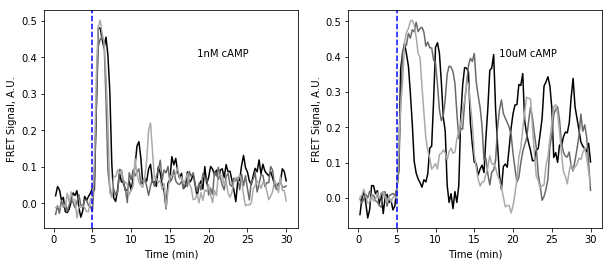

In [6]:
my_dir = r'C:/Users/ellin/Dropbox/AACP Science/Dicty model review drafts/figures/'
Sgro2015Figure1excel = pd.read_excel(my_dir+r'Sgro2015DataFormattedforPython.xlsx',sheetname='Figure1')

fig = plt.figure(figsize=(10, 4))
grid = plt.GridSpec(1,2)
ax1= fig.add_subplot(grid[0, 0])
ax1.plot(Sgro2015Figure1excel["Time (min)"],Sgro2015Figure1excel["Cell 1 FRET Trace (1nM)"],color='k')
ax1.plot(Sgro2015Figure1excel["Time (min)"],Sgro2015Figure1excel["Cell 2 FRET Trace (1nM)"],color='dimgrey')
ax1.plot(Sgro2015Figure1excel["Time (min)"],Sgro2015Figure1excel["Cell 3 FRET Trace (1nM)"],color='darkgrey')
ax1.axvline(x=5, ls='--',color = 'b')
ax1.set_ylabel(r'FRET Signal, A.U.'); ax1.set_xlabel('Time (min)')
ax1.text(0.7,0.8,' 1nM cAMP', ha='center',va='center',transform = ax1.transAxes)
ax2= fig.add_subplot(grid[0,1])
ax2.plot(Sgro2015Figure1excel["Time (min)"],Sgro2015Figure1excel["Cell 1 FRET Trace (10uM)"],color='k')
ax2.plot(Sgro2015Figure1excel["Time (min)"],Sgro2015Figure1excel["Cell 2 FRET Trace (10uM)"],color='dimgrey')
ax2.plot(Sgro2015Figure1excel["Time (min)"],Sgro2015Figure1excel["Cell 3 FRET Trace (10uM)"],color='darkgrey')
ax2.axvline(x=5, ls='--',color = 'b')
ax2.set_ylabel(r'FRET Signal, A.U.'); ax2.set_xlabel('Time (min)')
ax2.text(0.7,0.8,' 10uM cAMP', ha='center',va='center',transform = ax2.transAxes)
plt.show()

### 3. Matiel 1986
#### Set up parameters (from Table II in [Matiel & Goldbeter 1986](https://www.sciencedirect.com/science/article/pii/S0006349587832757?via%3Dihub) )

In [7]:
k1 = 0.036     # per min
k2 = 0.666    # per min
L1 = 10; L2 = 0.005 
c = 10;           # 0.15 ~ 50
lamda = 0.01; theta = 0.01; e =  1 ; q = 4000; sig= 0.6
v = 12; k = 4 # k prime in the paper
ki = 1.7; kt = 0.9; kc = 5.4; h = 5
Goldbeter3AgentParam={'k1':k1,'k2':k2,'L1':L1,'L2':L2, 'c':c, 'lamda':lamda,\
            'theta':theta, 'e':e, 'q':q,'sig':sig, 'v':v, 'k':k, \
            'ki':ki,'kt':kt, 'kc':kc,'h':h}
dt=0.001; t_tot=5*Nt_Goldbeter; t=list(np.arange(0,t_tot,dt))

#### Define step input trace

In [8]:
step_signal=1 # ow cAMPe input
# step_signal=10000 # high cAMPe input
stim_time_step=int(round(1/6*t_tot/dt)) # at this time step step input is applied
signal_trace=np.zeros(len(t))
signal_trace[stim_time_step:] = step_signal

#### Get $cAMP_i$ simulation response

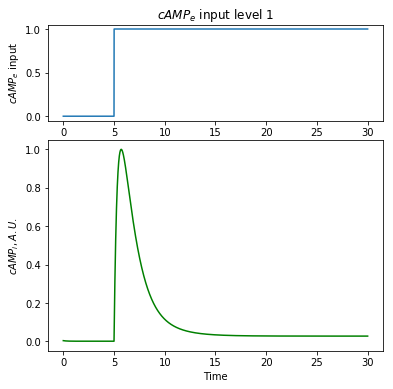

In [9]:
[t_plot_Goldbeter, b_trace, p_trace] = Goldbeter1986_SC(Goldbeter3AgentParam,dt,t,signal_trace)
t_plot_Goldbeter = t_plot_Goldbeter *6/(Nt_Goldbeter)

# Normalize height of cAMPi response trace to 1
b_trace = b_trace/(np.amax(b_trace)) 
plot_SC_spike_oscillation(t_plot_Goldbeter,signal_trace,b_trace,step_signal)


### 4. Maeda 2004
#### Set up parameters (from supplementary in [Maeda et al 2004](https://science.sciencemag.org/content/304/5672/875/tab-figures-data) )

In [10]:
k1=2.0; k2=0.9; k3=2.5; k4=1.5; k5=0.6
k6=0.8; k7=1.0; k8=1.3; k9=0.3; k10=0.8
k11=0.7; k12=4.9; k13=23; k14=4.5
MaedaAgentParam={'k1':k1,'k2':k2,'k3':k3,'k4':k4,'k5':k5,'k6':k6,\
            'k7':k7,'k8':k8,'k9':k9,'k10':k10,'k11':k11,'k12':k12,\
            'k13':k13,'k14':k14}
dt=0.001; t_tot=5*Nt_Maeda; t=list(np.arange(0,t_tot,dt))

#### Define step input trace

In [11]:
step_signal=1 # low cAMPe input
# step_signal=10000 # high cAMPe input
stim_time_step=int(round(1/6*t_tot/dt)) # at this time step input is applied
signal_trace=np.zeros(len(t))
signal_trace[stim_time_step:] = step_signal

#### Get $cAMP_i$ simulation response

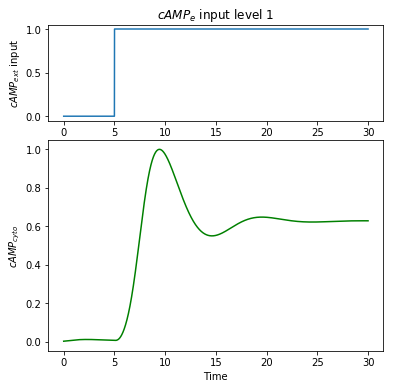

In [8]:
[t_plot_Maeda, cAMPi_trace, ERK2_trace] = Maeda2004_SC(MaedaAgentParam,dt,t,signal_trace)
t_plot_Maeda = np.array(t)*6/(Nt_Maeda)

# Normalize height of cAMPi response trace to 1
cAMPi_trace = cAMPi_trace/(np.amax(cAMPi_trace)) 
plot_SC_spike_oscillation(t_plot_Maeda,signal_trace,cAMPi_trace,step_signal)

### 5. Gregor 2010 
#### Set up parameters

In [12]:
Amax=20;  Abas=0.4 # uM
w=2*math.pi/6 # min-1
Vc=1.1e-9 # ml
St=1.33 # cm2
Sc=1.3e-6 # cm2
K=0.0004 # uM, 400 pM
c_sec= 3.6 # min-1
c_excite=1.01 # min-1
eta = 0.002 # noise strength
GregorAgentParam={'Amax':Amax,'Abas':Abas,'w':w,'Vc':Vc,'St':St,'Sc':Sc,'K':K,\
            'c_sec':c_sec,'c_excite':c_excite, 'eta':eta}
dt=0.001; t_tot=5*Nt_Gregor; t=list(np.arange(0,t_tot,dt))

#### Define step input trace

In [13]:
step_signal=1e-6 # low cAMPe input
# step_signal=1e-2# high cAMPe input
stim_time_step=int(round(1/6*t_tot/dt)) # at this time step input is applied
signal_trace=np.zeros(len(t))
signal_trace[stim_time_step:] = step_signal

#### Get $cAMP_i$ simulation response

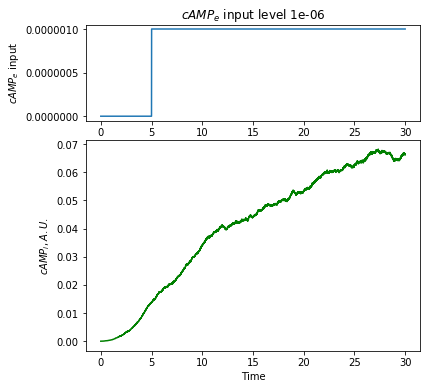

In [14]:
[t_plot_Gregor, gregor_thetai_trace, gregor_campCyto_trace] = Gregor2010_SC(GregorAgentParam,dt,t,signal_trace)
t_plot_Gregor =t_plot_Gregor*6/(Nt_Gregor)

# Normalize height of cAMPi response trace to 1
# gregor_campCyto_trace=(gregor_campCyto_trace-np.amin(gregor_campCyto_trace))/np.amax(gregor_campCyto_trace-np.amin(gregor_campCyto_trace)) # for sustained oscillation plot
gregor_campCyto_trace=gregor_campCyto_trace-np.amin(gregor_campCyto_trace) # for adaptive spike plot

plot_SC_spike_oscillation(t_plot_Gregor,signal_trace,gregor_campCyto_trace,step_signal)


### 6. Sgro 2015 
#### Set up parameters

In [15]:
e=0.1 # excitability
sigma = 0.15 # noise strength
tauA=0.09; tauR=tauA/e; g=0.5
SgroAgentParam={'e':e,'tauA':tauA,'tauR':tauR,'g':g,'c0':1.2,'sigma':sigma,'N':100,\
            'a':0.058,'alpha0':800,'alpha_pde':1000,'Kd':1e-5,'S':1e6,\
            'Nt':27,'Na':3.5,'offset_A':1.5,'flux_thrs':0}

dt=0.001 ; t_tot=5*Nt_Sgro; t=list(np.arange(0,t_tot,dt))

#### Define step input trace

In [16]:
step_signal=1 # low cAMPe input
# step_signal=10000 # high cAMPe input
stim_time_step=int(round(1/6*t_tot/dt)) # at this time step input is applied
signal_trace=np.zeros(len(t))
signal_trace[stim_time_step:] = step_signal

#### Get $cAMP_i$ simulation response

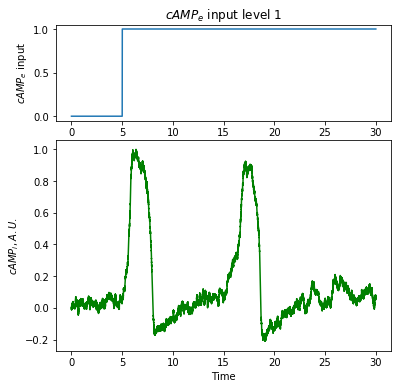

In [17]:
[t_plot_Sgro, A_trace_orig, A_trace_plot,R_trace_orig] = Sgro2015_SC(SgroAgentParam,dt,t,signal_trace)
t_plot_Sgro = t_plot_Sgro*6/(Nt_Sgro)

# Normalize height of cAMPi response trace to 1
A_trace_plot = A_trace_plot/(np.amax(A_trace_plot))
plot_SC_spike_oscillation(t_plot_Sgro,signal_trace, A_trace_plot,step_signal)


### 7. Kamino 2017
#### Set up parameters

In [18]:
tau=1.5; n=2; K=4; kt=2; delta=0.01
gamma=3 # cAMPe dilution/degradation rate 
rho= 0.01 # population density, doesn't matter for single cells
KaminoAgentParam={'tau':tau,'n':n,'K':K,'kt':kt,'delta':delta,\
               'gamma':gamma,'rho':rho}
dt=0.001; t_tot=5*Nt_Kamino; t=list(np.arange(0,t_tot,dt))

#### Define step input trace

In [19]:
step_signal=1 # low cAMPe input
# step_signal=10000 # high cAMPe input
stim_time_step=int(round(1/6*t_tot/dt)) # at this time step input is applied
signal_trace=np.zeros(len(t))
signal_trace[stim_time_step:] = step_signal

#### Get $cAMP_i$ simulation response

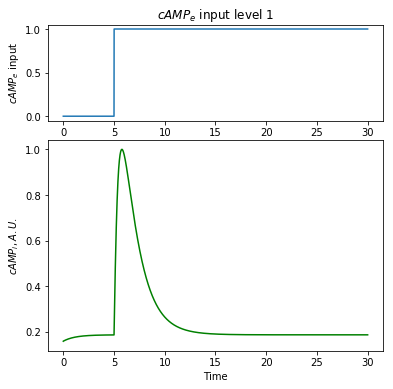

In [20]:
[t_plot_Kamino, y_trace, x_trace] = Kamino2017_SC(KaminoAgentParam,dt,t,signal_trace)
t_plot_Kamino = t_plot_Kamino*6/Nt_Kamino

# Normalize height of cAMPi response trace to 1
y_trace = y_trace/(np.amax(y_trace))
plot_SC_spike_oscillation(t_plot_Kamino,signal_trace, y_trace,step_signal)
